# Dog Breed Classification using CNN

# <a id='step0'></a>

## Step 1: Importing Datasets

##Importing Dog dataset



In [1]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob


def read_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets


train_files, train_targets = read_dataset('dog/train')
valid_files, valid_targets = read_dataset('dog/valid')
test_files, test_targets = read_dataset('dog/test')

dog_names = [item[20:-1] for item in sorted(glob("dog/train/*/"))]
dog_breeds = len(dog_names)

print('There are %d total dog categories.' % len(dog_names))
print('There are %s total dog images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training dog images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
print('There are %d test dog images.'% len(test_files))

Using TensorFlow backend.


There are 133 total dog categories.
There are 8351 total dog images.

There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.


In [2]:
print(train_files.shape)
print(test_files.shape)
print(valid_files.shape)

(6680,)
(836,)
(835,)


### Importing Human Dataset


In [3]:
import random
random.seed(8675309)

# load filenames in shuffled human dataset
human_files = np.array(glob("human/*/*"))
random.shuffle(human_files)

# print statistics about the dataset
print('There are %d total human images.' % len(human_files))

There are 4731 total human images.


---
<a id='step1'></a>
## Step 2: Detect Humans

True

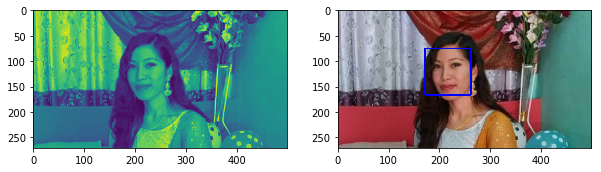

In [4]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

def human_detector(img_path, display = False):
    face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    if display:
        for (x,y,w,h) in faces:
            # bounding box to color image
            cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
            # convert BGR image to RGB for plotting
            cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            # display the image, along with bounding box
            plt.figure(figsize=[10,10])
            plt.subplot(121)
            plt.imshow(gray)
            plt.subplot(122)
            plt.imshow(cv_rgb)
    return len(faces) > 0

human_detector('human/ashmi/ashmi.jpg', True)

In [5]:
# returns "True" if face is detected in image stored at img_path
#def face_detector(a):
    #img = cv2.imread(a)
   # gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    #faces = face_cascade.detectMultiScale(gray)
    #return len(faces) > 0

In [6]:
#plt.show(faces)

### Testing  the accuracy of Human Face Detector 

In [7]:

human = human_files[:100]
dog = train_files[:100]

human_count = 0.0
total = 0.0
for img in human:
    isPerson = human_detector(img)
    if not isPerson:
        human_count += 1
total = 100 - human_count
percentage = (total/len(human)) * 100.0
print('Percentage of humans correctly classified as people: {}%'.format(percentage))

dog_count = 0.0
for img in dog:
    isPerson = human_detector(img)
    if isPerson:
        dog_count += 1
percentage = (dog_count/len(dog)) * 100.0
print('Percentage of dogs misclassified as people: {}%'.format(percentage))

Percentage of humans correctly classified as people: 99.0%
Percentage of dogs misclassified as people: 12.0%


---
<a id='step3'></a>
## Step 3: Detect Dogs

Using pre-trained model ResNet50 ALONG WITH the weights that have been trained on imagenet

In [8]:
from keras.applications.resnet50 import ResNet50

# define ResNet50 model"
ResNet50_model = ResNet50(weights='imagenet')

Instructions for updating:
Colocations handled automatically by placer.


### Step 4: Pre-process the Data



In [9]:
from keras.preprocessing import image                  
from tqdm import tqdm

img_width, img_height = 224, 224

def path_to_tensor(img_path):
    img = image.load_img(img_path, target_size=(img_width, img_height))
    #PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    #3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

In [10]:
# from PIL import ImageFile, ImageOps                           
# from keras.preprocessing import image                  
# from tqdm import tqdm

# def path_to_tensor(img_path):

#     img = image.load_img(img_path, target_size=(224, 224))

#     x = image.img_to_array(img)
#     #Reshape to include batches as well
#     return np.expand_dims(x, axis=0)

### Step5: Making Predictions with ResNet-50


In [11]:
from keras.applications.resnet50 import preprocess_input, decode_predictions

def ResNet50_predict_labels(img_path):
    # returns prediction vector for image located at img_path
    img = preprocess_input(path_to_tensor(img_path))
    return np.argmax(ResNet50_model.predict(img))

### Predicting the dog with Resnet50



In [12]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151))
    

### Testing the accuracy of the Dog Detector



In [13]:
# Files already loaded in previous cell 

# Vectorize the face dectector function
dog_vfunc = np.vectorize(dog_detector)

# Detect dogs in both sets
human_dogs = dog_vfunc(human)
dog_dogs = dog_vfunc(dog)

# Calculate and print percentage of faces in each set
print('Dogs detected in {:.2f}% of the sample human dataset.'.format((sum(human_dogs)/len(human_dogs))*100))
print('Dogs detected in {:.2f}% of the sample dog dataset.'.format((sum(dog_dogs)/len(dog_dogs))*100))

Dogs detected in 2.00% of the sample human dataset.
Dogs detected in 100.00% of the sample dog dataset.


In [14]:
#uman_dogs

As you can see, the dog detector performs better than the human face detector, only detecting dogs in 1% of the human photos. 

---
<a id='step6'></a>
## Step 6: Create a CNN to Classify Dog Breeds (from Scratch)


### Pre-process the Data

We rescale the images by dividing every pixel in every image by 255.

In [15]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|██████████| 836/836 [00:11<00:00, 70.54it/s]


train_tensors shape =(6680, 224, 224, 3), min=0.000, max=1.000


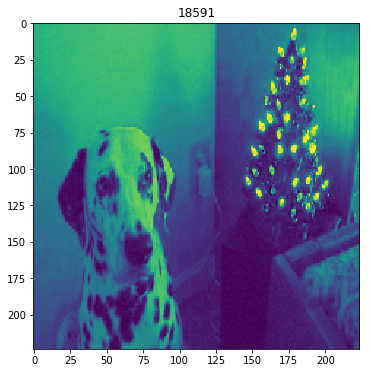

In [16]:
plt.figure(figsize=(6,6))
plt.imshow(train_tensors[1][:,:,0])
plt.title(test_tensors[1].argmax());
#print(train_tensors[:1])
print('train_tensors shape =%s, min=%.3f, max=%.3f' % (train_tensors.shape, train_tensors.min(), train_tensors.max()))


### Model Architecture(using different CNN layers)


In [18]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, AveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential
from keras import backend as K
from keras import metrics

model = Sequential()
a = model.add(Conv2D(filters = 16, kernel_size = (5,5), strides = (2,2), padding = 'valid', activation = 'relu', 
          input_shape = (img_width, img_height, 3))) #RGB image

model.add(Conv2D(filters = 32, kernel_size = (5,5), strides = (4,4), padding = 'valid', activation = 'relu'))
model.add(MaxPooling2D(pool_size=(3, 3), strides=None, padding='valid'))

model.add(Conv2D(filters = 64, kernel_size = (2,2), strides = (2,2), padding = 'valid', activation = 'relu'))

model.add(GlobalAveragePooling2D())
model.add(Dense(200, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(dog_breeds, activation='softmax'))
model.summary()


#....................................


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 110, 110, 16)      1216      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 27, 27, 32)        12832     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 9, 9, 32)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 64)          8256      
_________________________________________________________________
global_average_pooling2d_1 ( (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 200)               13000     
___________________________

In [19]:
#model.get_config()

In [20]:
model.layers[0].get_config()  #configuration of first layer

{'name': 'conv2d_1',
 'trainable': True,
 'batch_input_shape': (None, 224, 224, 3),
 'dtype': 'float32',
 'filters': 16,
 'kernel_size': (5, 5),
 'strides': (2, 2),
 'padding': 'valid',
 'data_format': 'channels_last',
 'dilation_rate': (1, 1),
 'activation': 'relu',
 'use_bias': True,
 'kernel_initializer': {'class_name': 'VarianceScaling',
  'config': {'scale': 1.0,
   'mode': 'fan_avg',
   'distribution': 'uniform',
   'seed': None}},
 'bias_initializer': {'class_name': 'Zeros', 'config': {}},
 'kernel_regularizer': None,
 'bias_regularizer': None,
 'activity_regularizer': None,
 'kernel_constraint': None,
 'bias_constraint': None}

In [21]:
#model.layers[0].bias.value()

### Compile the Model

In [22]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

### Train the Model

Train the model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss.

In [23]:
from keras.callbacks import ModelCheckpoint  

epochs = 5

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)

model.load_weights('saved_models/weights.best.from_scratch.hdf5')

a = model.fit(train_tensors, train_targets, 
          validation_data=(valid_tensors, valid_targets),
          epochs=epochs, batch_size=20, callbacks=[checkpointer], verbose=1)

Instructions for updating:
Use tf.cast instead.
Train on 6680 samples, validate on 835 samples
Epoch 1/5


4180/6680 [=================>............] - ETA: 9:30 - loss: 2.7378 - acc: 0.300 - ETA: 5:30 - loss: 3.3398 - acc: 0.275 - ETA: 4:08 - loss: 3.2417 - acc: 0.233 - ETA: 3:27 - loss: 3.1476 - acc: 0.275 - ETA: 3:02 - loss: 3.1704 - acc: 0.250 - ETA: 2:45 - loss: 3.1072 - acc: 0.250 - ETA: 2:33 - loss: 3.0450 - acc: 0.250 - ETA: 2:25 - loss: 2.9196 - acc: 0.293 - ETA: 2:18 - loss: 2.8684 - acc: 0.283 - ETA: 2:13 - loss: 2.8617 - acc: 0.270 - ETA: 2:08 - loss: 2.8366 - acc: 0.268 - ETA: 2:04 - loss: 2.8324 - acc: 0.254 - ETA: 2:01 - loss: 2.8107 - acc: 0.261 - ETA: 1:58 - loss: 2.8159 - acc: 0.264 - ETA: 1:56 - loss: 2.8004 - acc: 0.266 - ETA: 1:53 - loss: 2.8574 - acc: 0.259 - ETA: 1:51 - loss: 2.8501 - acc: 0.264 - ETA: 1:50 - loss: 2.8086 - acc: 0.280 - ETA: 1:48 - loss: 2.8075 - acc: 0.281 - ETA: 1:46 - loss: 2.8036 - acc: 0.282 - ETA: 1:45 - loss: 2.8204 - acc: 0.281 - ETA: 1:43 - loss: 2.8177 - acc: 0.272 - ETA: 1:42 - loss: 2.8094 - acc: 0.267 - ETA: 1:41 - loss: 2.7998 - acc: 0.2

4180/6680 [=================>............] - ETA: 1:25 - loss: 2.4804 - acc: 0.300 - ETA: 1:25 - loss: 2.3268 - acc: 0.375 - ETA: 1:27 - loss: 2.4471 - acc: 0.333 - ETA: 1:30 - loss: 2.4799 - acc: 0.312 - ETA: 1:29 - loss: 2.4582 - acc: 0.330 - ETA: 1:30 - loss: 2.5159 - acc: 0.308 - ETA: 1:29 - loss: 2.4927 - acc: 0.321 - ETA: 1:28 - loss: 2.4118 - acc: 0.343 - ETA: 1:27 - loss: 2.4117 - acc: 0.355 - ETA: 1:26 - loss: 2.4190 - acc: 0.365 - ETA: 1:25 - loss: 2.4261 - acc: 0.363 - ETA: 1:25 - loss: 2.4205 - acc: 0.370 - ETA: 1:24 - loss: 2.4558 - acc: 0.365 - ETA: 1:24 - loss: 2.4840 - acc: 0.364 - ETA: 1:23 - loss: 2.4651 - acc: 0.360 - ETA: 1:23 - loss: 2.4532 - acc: 0.356 - ETA: 1:23 - loss: 2.4719 - acc: 0.347 - ETA: 1:23 - loss: 2.4791 - acc: 0.338 - ETA: 1:22 - loss: 2.4560 - acc: 0.342 - ETA: 1:22 - loss: 2.4504 - acc: 0.345 - ETA: 1:22 - loss: 2.4557 - acc: 0.352 - ETA: 1:21 - loss: 2.4534 - acc: 0.356 - ETA: 1:21 - loss: 2.4873 - acc: 0.347 - ETA: 1:21 - loss: 2.4923 - acc: 0.3

6680/6680 [==============================] - ETA: 32s - loss: 2.6054 - acc: 0.30 - ETA: 32s - loss: 2.6055 - acc: 0.30 - ETA: 32s - loss: 2.6063 - acc: 0.30 - ETA: 31s - loss: 2.6072 - acc: 0.30 - ETA: 31s - loss: 2.6074 - acc: 0.30 - ETA: 31s - loss: 2.6081 - acc: 0.30 - ETA: 31s - loss: 2.6087 - acc: 0.30 - ETA: 30s - loss: 2.6078 - acc: 0.30 - ETA: 30s - loss: 2.6068 - acc: 0.30 - ETA: 30s - loss: 2.6040 - acc: 0.30 - ETA: 29s - loss: 2.6038 - acc: 0.30 - ETA: 29s - loss: 2.6010 - acc: 0.30 - ETA: 29s - loss: 2.6017 - acc: 0.30 - ETA: 29s - loss: 2.6030 - acc: 0.30 - ETA: 28s - loss: 2.6035 - acc: 0.30 - ETA: 28s - loss: 2.6036 - acc: 0.30 - ETA: 28s - loss: 2.6046 - acc: 0.30 - ETA: 28s - loss: 2.6031 - acc: 0.30 - ETA: 27s - loss: 2.6030 - acc: 0.30 - ETA: 27s - loss: 2.6056 - acc: 0.30 - ETA: 27s - loss: 2.6031 - acc: 0.30 - ETA: 27s - loss: 2.6017 - acc: 0.30 - ETA: 26s - loss: 2.6021 - acc: 0.30 - ETA: 26s - loss: 2.6024 - acc: 0.30 - ETA: 26s - loss: 2.6051 - acc: 0.30 - ETA: 

4200/6680 [=================>............] - ETA: 1:38 - loss: 3.2576 - acc: 0.250 - ETA: 1:42 - loss: 3.0521 - acc: 0.250 - ETA: 1:37 - loss: 2.7170 - acc: 0.283 - ETA: 1:34 - loss: 2.8563 - acc: 0.250 - ETA: 1:33 - loss: 2.8316 - acc: 0.250 - ETA: 1:31 - loss: 2.7925 - acc: 0.258 - ETA: 1:31 - loss: 2.7262 - acc: 0.278 - ETA: 1:30 - loss: 2.6793 - acc: 0.268 - ETA: 1:29 - loss: 2.6501 - acc: 0.272 - ETA: 1:29 - loss: 2.6785 - acc: 0.265 - ETA: 1:29 - loss: 2.6538 - acc: 0.281 - ETA: 1:29 - loss: 2.6773 - acc: 0.270 - ETA: 1:27 - loss: 2.6988 - acc: 0.269 - ETA: 1:28 - loss: 2.6628 - acc: 0.271 - ETA: 1:27 - loss: 2.6342 - acc: 0.270 - ETA: 1:26 - loss: 2.6062 - acc: 0.278 - ETA: 1:26 - loss: 2.5811 - acc: 0.285 - ETA: 1:25 - loss: 2.5811 - acc: 0.283 - ETA: 1:25 - loss: 2.5819 - acc: 0.281 - ETA: 1:25 - loss: 2.5554 - acc: 0.295 - ETA: 1:24 - loss: 2.5451 - acc: 0.295 - ETA: 1:24 - loss: 2.5626 - acc: 0.295 - ETA: 1:24 - loss: 2.5480 - acc: 0.297 - ETA: 1:23 - loss: 2.5192 - acc: 0.3

4300/6680 [==================>...........] - ETA: 33s - loss: 2.7512 - acc: 0.30 - ETA: 32s - loss: 2.7817 - acc: 0.27 - ETA: 32s - loss: 2.8982 - acc: 0.21 - ETA: 32s - loss: 2.8040 - acc: 0.25 - ETA: 33s - loss: 2.7160 - acc: 0.28 - ETA: 33s - loss: 2.6719 - acc: 0.30 - ETA: 33s - loss: 2.5657 - acc: 0.30 - ETA: 33s - loss: 2.6847 - acc: 0.26 - ETA: 33s - loss: 2.6258 - acc: 0.28 - ETA: 33s - loss: 2.6253 - acc: 0.29 - ETA: 33s - loss: 2.5493 - acc: 0.31 - ETA: 33s - loss: 2.5490 - acc: 0.30 - ETA: 33s - loss: 2.5569 - acc: 0.30 - ETA: 33s - loss: 2.5620 - acc: 0.30 - ETA: 33s - loss: 2.5458 - acc: 0.30 - ETA: 33s - loss: 2.5965 - acc: 0.30 - ETA: 33s - loss: 2.5797 - acc: 0.31 - ETA: 32s - loss: 2.5540 - acc: 0.32 - ETA: 32s - loss: 2.5476 - acc: 0.32 - ETA: 32s - loss: 2.5252 - acc: 0.33 - ETA: 32s - loss: 2.5120 - acc: 0.33 - ETA: 32s - loss: 2.4877 - acc: 0.34 - ETA: 32s - loss: 2.4841 - acc: 0.34 - ETA: 31s - loss: 2.4894 - acc: 0.33 - ETA: 31s - loss: 2.4857 - acc: 0.33 - ETA: 

6680/6680 [==============================] - ETA: 11s - loss: 2.5728 - acc: 0.31 - ETA: 11s - loss: 2.5736 - acc: 0.31 - ETA: 11s - loss: 2.5741 - acc: 0.31 - ETA: 11s - loss: 2.5760 - acc: 0.30 - ETA: 11s - loss: 2.5749 - acc: 0.31 - ETA: 11s - loss: 2.5771 - acc: 0.31 - ETA: 11s - loss: 2.5769 - acc: 0.31 - ETA: 11s - loss: 2.5763 - acc: 0.31 - ETA: 11s - loss: 2.5753 - acc: 0.31 - ETA: 10s - loss: 2.5761 - acc: 0.30 - ETA: 10s - loss: 2.5756 - acc: 0.30 - ETA: 10s - loss: 2.5749 - acc: 0.30 - ETA: 10s - loss: 2.5733 - acc: 0.31 - ETA: 10s - loss: 2.5733 - acc: 0.30 - ETA: 10s - loss: 2.5735 - acc: 0.30 - ETA: 10s - loss: 2.5723 - acc: 0.30 - ETA: 10s - loss: 2.5734 - acc: 0.30 - ETA: 10s - loss: 2.5744 - acc: 0.30 - ETA: 10s - loss: 2.5733 - acc: 0.30 - ETA: 9s - loss: 2.5739 - acc: 0.3094 - ETA: 9s - loss: 2.5736 - acc: 0.309 - ETA: 9s - loss: 2.5753 - acc: 0.308 - ETA: 9s - loss: 2.5759 - acc: 0.308 - ETA: 9s - loss: 2.5787 - acc: 0.307 - ETA: 9s - loss: 2.5811 - acc: 0.307 - ETA:

4300/6680 [==================>...........] - ETA: 32s - loss: 2.4080 - acc: 0.40 - ETA: 32s - loss: 2.5247 - acc: 0.40 - ETA: 32s - loss: 2.4648 - acc: 0.36 - ETA: 33s - loss: 2.5197 - acc: 0.33 - ETA: 33s - loss: 2.4122 - acc: 0.34 - ETA: 33s - loss: 2.3104 - acc: 0.35 - ETA: 33s - loss: 2.3033 - acc: 0.37 - ETA: 32s - loss: 2.3703 - acc: 0.37 - ETA: 33s - loss: 2.4071 - acc: 0.37 - ETA: 32s - loss: 2.3379 - acc: 0.40 - ETA: 32s - loss: 2.3091 - acc: 0.40 - ETA: 32s - loss: 2.3985 - acc: 0.39 - ETA: 32s - loss: 2.3832 - acc: 0.40 - ETA: 32s - loss: 2.3484 - acc: 0.41 - ETA: 32s - loss: 2.3358 - acc: 0.41 - ETA: 32s - loss: 2.3700 - acc: 0.39 - ETA: 31s - loss: 2.4014 - acc: 0.38 - ETA: 31s - loss: 2.4143 - acc: 0.37 - ETA: 31s - loss: 2.3951 - acc: 0.38 - ETA: 31s - loss: 2.4486 - acc: 0.37 - ETA: 31s - loss: 2.4506 - acc: 0.37 - ETA: 31s - loss: 2.4601 - acc: 0.37 - ETA: 31s - loss: 2.4790 - acc: 0.36 - ETA: 31s - loss: 2.4724 - acc: 0.36 - ETA: 31s - loss: 2.5028 - acc: 0.36 - ETA: 

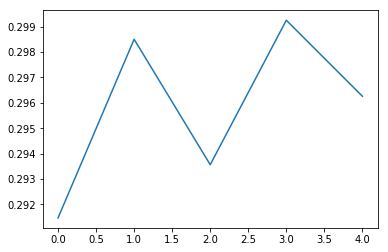

In [23]:
from matplotlib import pyplot
pyplot.plot(a.history['acc'])
pyplot.show()

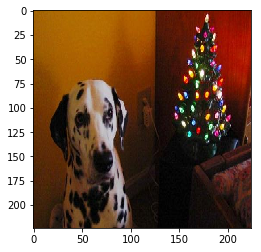

In [24]:
plt.imshow(train_tensors[1])


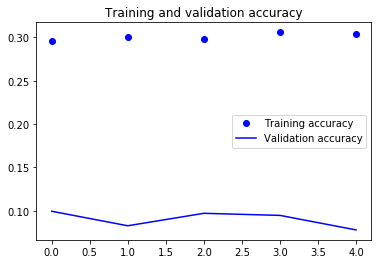

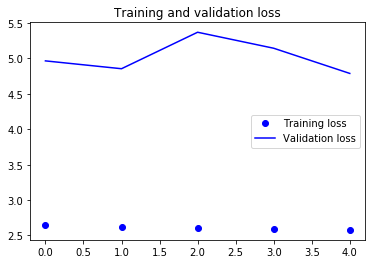

In [24]:
accuracy = a.history['acc']
val_accuracy = a.history['val_acc']
loss = a.history['loss']
val_loss = a.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()


# Visualizing the layers 

In [25]:
from keras import models
layer_outputs = [layer.output for layer in model.layers[:12]] # Extracts the outputs of the top 12 layers
activation_model = models.Model(inputs=model.input, outputs=layer_outputs) # Creates a model that will return these outputs, given the model input

In [26]:
activations = activation_model.predict(train_tensors)

In [28]:
first_layer_activation = activations[0]
print(first_layer_activation.shape)

(6680, 110, 110, 16)


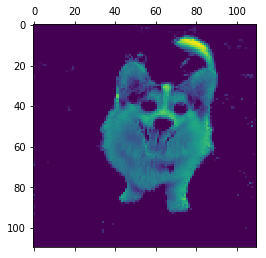

In [29]:
plt.matshow(first_layer_activation[100, :, :, 4], cmap='viridis')

C:\Users\User\Anaconda3\envs\my_env\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide


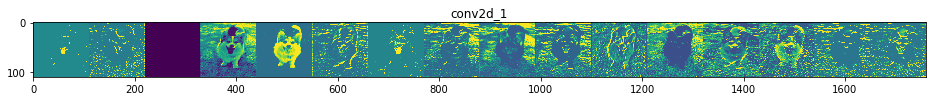

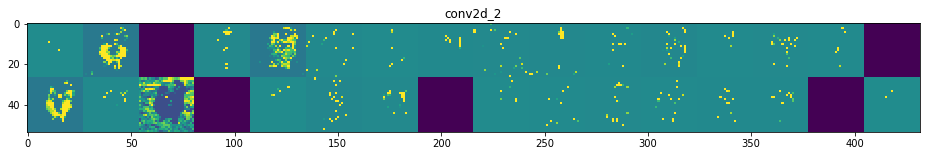

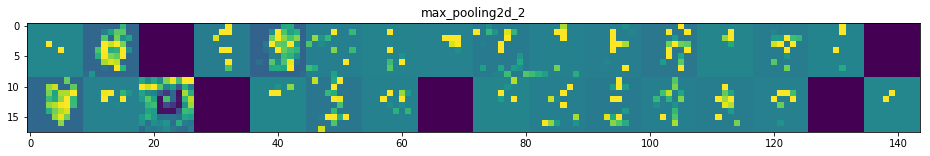

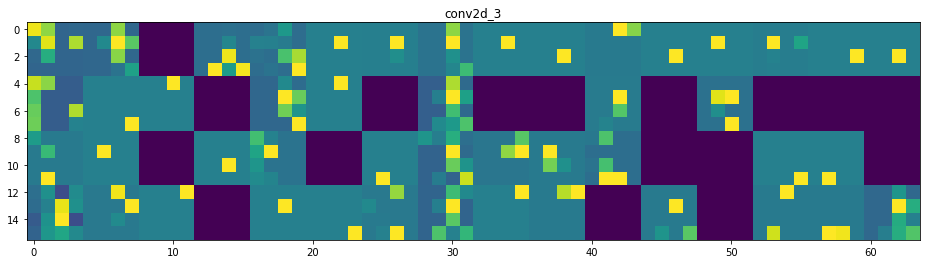

In [30]:
layer_names = []
for layer in model.layers[:4]:
    layer_names.append(layer.name) # Names of the layers, so you can have them as part of your plot
    
images_per_row = 16

for layer_name, layer_activation in zip(layer_names, activations): # Displays the feature maps
    n_features = layer_activation.shape[-1] # Number of features in the feature map
    size = layer_activation.shape[1] #The feature map has shape (1, size, size, n_features).
    n_cols = n_features // images_per_row # Tiles the activation channels in this matrix
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    for col in range(n_cols): # Tiles each filter into a big horizontal grid
        for row in range(images_per_row):
            channel_image = layer_activation[100,
                                             :, :,
                                             col * images_per_row + row]
            channel_image -= channel_image.mean() # Post-processes the feature to make it visually palatable
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size, # Displays the grid
                         row * size : (row + 1) * size] = channel_image
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

### Load the Model with the Best Validation Loss

In [31]:
model.load_weights('saved_models/weights.best.from_scratch.hdf5')

### Test the Model

Evaluate the model on the test dataset of dog images.

In [32]:
# get index of predicted dog breed for each image in test set
dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)
#predictions = model.predict(test_tensors) 
#matrix = confusion_matrix( test_targets, predictions)




from sklearn.metrics import confusion_matrix
Y_prediction = model.predict(test_tensors)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_prediction,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(test_targets,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true,Y_pred_classes)








Test accuracy: 8.0144%


In [33]:
print (confusion_mtx)

[[2 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [35]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import itertools
from sklearn.metrics import confusion_matrix


def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                      horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()


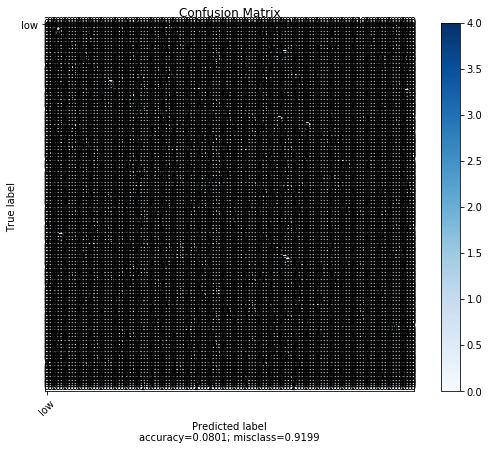

In [36]:
plot_confusion_matrix((confusion_mtx), normalize    = False, target_names = [ 'low'], title        = "Confusion Matrix")


Already, this network performs significantly better than random chance. However, we can supercharge this network by leveraging transfer learning to start with convolutional layers which have been pre-trained for object recognition in natural photos. 

---
<a id='step7'></a>
## Step 7: Create a CNN to Classify Dog Breeds (using Transfer Learning)



### Obtain Bottleneck Features

Extract the bottleneck features corresponding to the train, test, and validation sets.

In [27]:
import numpy as np
bottleneck_features = np.load('bottleneck_features/DogInceptionV3Data.npz')
train_InceptionV3 = bottleneck_features['train']
valid_InceptionV3 = bottleneck_features['valid']
test_InceptionV3 = bottleneck_features['test']

In [28]:
#train_InceptionV3[0]


In [29]:
train_InceptionV3.shape[1:]

(5, 5, 2048)

### Model Architecture

First, I used a GlobalAveragePooling layer to flatten the features into a vector that could be fed into a fully-connected layer. I was also experiencing some overfitting even with dropout, so I decided to regularize the dense layer's weights. Lastly, the softmax layer predicts the probability of each breed. 

In [56]:
from keras import regularizers
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, AveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

inception_model = Sequential()
inception_model.add(GlobalAveragePooling2D(input_shape=train_InceptionV3.shape[1:]))
inception_model.add(Dense(150, activation='relu', kernel_regularizer=regularizers.l2(0.005)))
inception_model.add(Dropout(0.4))
inception_model.add(Dense(dog_breeds, activation='softmax'))

inception_model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_4 ( (None, 2048)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 150)               307350    
_________________________________________________________________
dropout_3 (Dropout)          (None, 150)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 133)               20083     
Total params: 327,433
Trainable params: 327,433
Non-trainable params: 0
_________________________________________________________________


In [57]:
#plt.matshow(inception_model)

In [58]:
plt.show(inception_model)

### Compile the Model

In [59]:
inception_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### Train the Model

Train the model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss. 

In [60]:
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.InceptionV3.hdf5', 
                               verbose=1, save_best_only=True)

q = inception_model.fit(train_InceptionV3, train_targets, 
          validation_data=(valid_InceptionV3, valid_targets),
          epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/20
6680/6680 [==============================] - ETA: 3:38 - loss: 7.1061 - acc: 0.0000e+0 - ETA: 29s - loss: 6.7661 - acc: 0.0188    - ETA: 16s - loss: 6.3640 - acc: 0.04 - ETA: 11s - loss: 6.1893 - acc: 0.05 - ETA: 9s - loss: 6.0375 - acc: 0.0707 - ETA: 7s - loss: 5.8766 - acc: 0.091 - ETA: 6s - loss: 5.7420 - acc: 0.115 - ETA: 6s - loss: 5.6151 - acc: 0.133 - ETA: 5s - loss: 5.4675 - acc: 0.149 - ETA: 5s - loss: 5.3636 - acc: 0.164 - ETA: 5s - loss: 5.2427 - acc: 0.181 - ETA: 4s - loss: 5.1472 - acc: 0.199 - ETA: 4s - loss: 5.0496 - acc: 0.216 - ETA: 4s - loss: 4.9791 - acc: 0.224 - ETA: 4s - loss: 4.8744 - acc: 0.238 - ETA: 3s - loss: 4.7702 - acc: 0.255 - ETA: 3s - loss: 4.6822 - acc: 0.268 - ETA: 3s - loss: 4.6090 - acc: 0.277 - ETA: 3s - loss: 4.5364 - acc: 0.285 - ETA: 3s - loss: 4.4598 - acc: 0.293 - ETA: 3s - loss: 4.3825 - acc: 0.303 - ETA: 2s - loss: 4.3125 - acc: 0.316 - ETA: 2s - loss: 4.2313 - acc: 0.330 - ETA: 2s - l

6680/6680 [==============================] - ETA: 2s - loss: 0.7418 - acc: 0.950 - ETA: 2s - loss: 1.2921 - acc: 0.800 - ETA: 2s - loss: 1.2763 - acc: 0.783 - ETA: 2s - loss: 1.2389 - acc: 0.784 - ETA: 2s - loss: 1.2882 - acc: 0.758 - ETA: 2s - loss: 1.2795 - acc: 0.755 - ETA: 2s - loss: 1.2689 - acc: 0.757 - ETA: 2s - loss: 1.2518 - acc: 0.764 - ETA: 2s - loss: 1.2682 - acc: 0.758 - ETA: 2s - loss: 1.2802 - acc: 0.757 - ETA: 2s - loss: 1.2771 - acc: 0.755 - ETA: 2s - loss: 1.2716 - acc: 0.755 - ETA: 1s - loss: 1.2746 - acc: 0.752 - ETA: 1s - loss: 1.2973 - acc: 0.748 - ETA: 1s - loss: 1.3037 - acc: 0.746 - ETA: 1s - loss: 1.2972 - acc: 0.747 - ETA: 1s - loss: 1.2745 - acc: 0.754 - ETA: 1s - loss: 1.2757 - acc: 0.753 - ETA: 1s - loss: 1.2726 - acc: 0.755 - ETA: 1s - loss: 1.2646 - acc: 0.758 - ETA: 1s - loss: 1.2789 - acc: 0.756 - ETA: 1s - loss: 1.2881 - acc: 0.755 - ETA: 1s - loss: 1.2874 - acc: 0.754 - ETA: 1s - loss: 1.2776 - acc: 0.758 - ETA: 1s - loss: 1.2747 - acc: 0.758 - ETA: 


Epoch 00007: val_loss did not improve from 0.98435
Epoch 8/20
6680/6680 [==============================] - ETA: 2s - loss: 1.0593 - acc: 0.750 - ETA: 2s - loss: 0.8906 - acc: 0.843 - ETA: 2s - loss: 1.0515 - acc: 0.810 - ETA: 2s - loss: 1.0281 - acc: 0.806 - ETA: 2s - loss: 1.0441 - acc: 0.793 - ETA: 2s - loss: 1.0437 - acc: 0.795 - ETA: 2s - loss: 1.0277 - acc: 0.797 - ETA: 2s - loss: 1.0254 - acc: 0.798 - ETA: 2s - loss: 1.0371 - acc: 0.799 - ETA: 2s - loss: 1.0553 - acc: 0.793 - ETA: 2s - loss: 1.0641 - acc: 0.787 - ETA: 1s - loss: 1.0398 - acc: 0.795 - ETA: 1s - loss: 1.0499 - acc: 0.792 - ETA: 1s - loss: 1.0603 - acc: 0.796 - ETA: 1s - loss: 1.0622 - acc: 0.797 - ETA: 1s - loss: 1.0706 - acc: 0.795 - ETA: 1s - loss: 1.0875 - acc: 0.791 - ETA: 1s - loss: 1.0936 - acc: 0.790 - ETA: 1s - loss: 1.0965 - acc: 0.790 - ETA: 1s - loss: 1.1061 - acc: 0.787 - ETA: 1s - loss: 1.1047 - acc: 0.786 - ETA: 1s - loss: 1.1043 - acc: 0.786 - ETA: 1s - loss: 1.1021 - acc: 0.785 - ETA: 1s - loss: 1.

6680/6680 [==============================] - ETA: 2s - loss: 1.3558 - acc: 0.750 - ETA: 2s - loss: 1.0830 - acc: 0.768 - ETA: 2s - loss: 1.0944 - acc: 0.773 - ETA: 2s - loss: 1.1597 - acc: 0.763 - ETA: 2s - loss: 1.1442 - acc: 0.769 - ETA: 2s - loss: 1.1196 - acc: 0.775 - ETA: 2s - loss: 1.0902 - acc: 0.783 - ETA: 2s - loss: 1.1012 - acc: 0.778 - ETA: 2s - loss: 1.1339 - acc: 0.766 - ETA: 2s - loss: 1.1175 - acc: 0.772 - ETA: 2s - loss: 1.1111 - acc: 0.769 - ETA: 1s - loss: 1.0861 - acc: 0.778 - ETA: 1s - loss: 1.0771 - acc: 0.780 - ETA: 1s - loss: 1.0736 - acc: 0.781 - ETA: 1s - loss: 1.0653 - acc: 0.785 - ETA: 1s - loss: 1.0812 - acc: 0.780 - ETA: 1s - loss: 1.0863 - acc: 0.781 - ETA: 1s - loss: 1.0807 - acc: 0.784 - ETA: 1s - loss: 1.0751 - acc: 0.784 - ETA: 1s - loss: 1.0690 - acc: 0.787 - ETA: 1s - loss: 1.0798 - acc: 0.785 - ETA: 1s - loss: 1.0872 - acc: 0.783 - ETA: 1s - loss: 1.0858 - acc: 0.785 - ETA: 1s - loss: 1.0858 - acc: 0.786 - ETA: 1s - loss: 1.0905 - acc: 0.786 - ETA: 

6680/6680 [==============================] - ETA: 2s - loss: 1.7479 - acc: 0.550 - ETA: 2s - loss: 0.9632 - acc: 0.793 - ETA: 2s - loss: 0.9456 - acc: 0.810 - ETA: 2s - loss: 0.9397 - acc: 0.818 - ETA: 2s - loss: 0.9813 - acc: 0.810 - ETA: 2s - loss: 0.9821 - acc: 0.812 - ETA: 2s - loss: 1.0096 - acc: 0.803 - ETA: 2s - loss: 1.0117 - acc: 0.803 - ETA: 2s - loss: 0.9955 - acc: 0.807 - ETA: 2s - loss: 1.0146 - acc: 0.795 - ETA: 1s - loss: 1.0151 - acc: 0.794 - ETA: 1s - loss: 1.0283 - acc: 0.789 - ETA: 1s - loss: 1.0235 - acc: 0.793 - ETA: 1s - loss: 1.0145 - acc: 0.795 - ETA: 1s - loss: 1.0251 - acc: 0.793 - ETA: 1s - loss: 1.0207 - acc: 0.795 - ETA: 1s - loss: 1.0233 - acc: 0.793 - ETA: 1s - loss: 1.0276 - acc: 0.793 - ETA: 1s - loss: 1.0284 - acc: 0.791 - ETA: 1s - loss: 1.0414 - acc: 0.789 - ETA: 1s - loss: 1.0432 - acc: 0.789 - ETA: 1s - loss: 1.0383 - acc: 0.789 - ETA: 1s - loss: 1.0471 - acc: 0.788 - ETA: 1s - loss: 1.0618 - acc: 0.786 - ETA: 1s - loss: 1.0615 - acc: 0.785 - ETA: 

Epoch 00019: val_loss did not improve from 0.92779
Epoch 20/20
6680/6680 [==============================] - ETA: 2s - loss: 0.8289 - acc: 0.750 - ETA: 2s - loss: 1.0908 - acc: 0.756 - ETA: 2s - loss: 0.9645 - acc: 0.803 - ETA: 2s - loss: 0.9180 - acc: 0.813 - ETA: 2s - loss: 0.9711 - acc: 0.798 - ETA: 2s - loss: 0.9808 - acc: 0.795 - ETA: 2s - loss: 1.0029 - acc: 0.789 - ETA: 2s - loss: 0.9975 - acc: 0.788 - ETA: 2s - loss: 0.9765 - acc: 0.799 - ETA: 2s - loss: 0.9808 - acc: 0.794 - ETA: 2s - loss: 1.0153 - acc: 0.788 - ETA: 1s - loss: 1.0200 - acc: 0.789 - ETA: 1s - loss: 1.0281 - acc: 0.785 - ETA: 1s - loss: 1.0255 - acc: 0.790 - ETA: 1s - loss: 1.0390 - acc: 0.784 - ETA: 1s - loss: 1.0276 - acc: 0.788 - ETA: 1s - loss: 1.0280 - acc: 0.789 - ETA: 1s - loss: 1.0155 - acc: 0.791 - ETA: 1s - loss: 1.0217 - acc: 0.790 - ETA: 1s - loss: 1.0294 - acc: 0.789 - ETA: 1s - loss: 1.0401 - acc: 0.784 - ETA: 1s - loss: 1.0458 - acc: 0.785 - ETA: 1s - loss: 1.0449 - acc: 0.786 - ETA: 1s - loss: 1.

### Load the Model with the Best Validation Loss

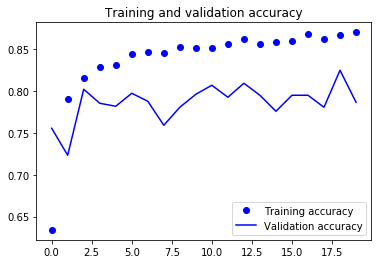

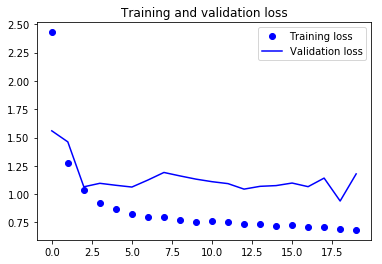

In [52]:
accuracy = q.history['acc']
val_accuracy = q.history['val_acc']
loss = q.history['loss']
val_loss = q.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [53]:
inception_model.save_weights('human/weights.best.InceptionV3.hdf5')
print("save model to disk")

save model to disk


In [54]:
inception_model.load_weights('human/weights.best.InceptionV3.hdf5')

### Test the Model

Evaluate the model on the test dataset of dog images.

In [55]:
# get index of predicted dog breed for each image in test set
InceptionV3_predictions = [np.argmax(inception_model.predict(np.expand_dims(feature, axis=0))) for feature in test_InceptionV3]

# report test accuracy
test_accuracy = 100*np.sum(np.array(InceptionV3_predictions)==np.argmax(test_targets, axis=1))/len(InceptionV3_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

# Y_prediction = model.predict(valid_InceptionV3)
# Convert predictions classes to one hot vectors 
# Y_pred_classes = np.argmax(Y_prediction,axis = 1) 
# Convert validation observations to one hot vectors
# Y_true = np.argmax(valid_targets,axis = 1) 
# compute the confusion matrix
# confusion_mtx = confusion_matrix(Y_true,Y_pred_classes)


Test accuracy: 74.7608%


In [47]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import itertools
from sklearn.metrics import confusion_matrix


def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 4 if normalize else cm.max() / 3
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                      horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()


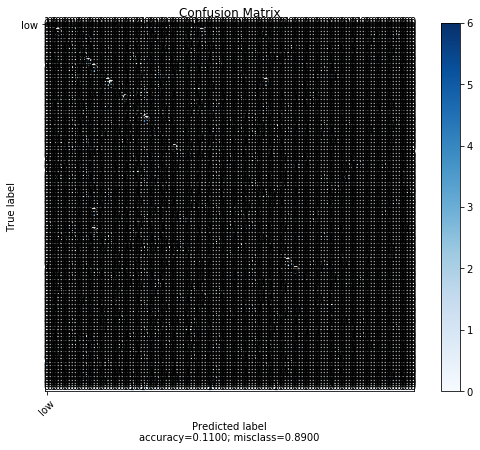

In [51]:
plot_confusion_matrix((confusion_mtx), normalize    = False, target_names = [ 'low'], title        = "Confusion Matrix")


###  Predict Dog Breed with the Model

Now, we'll write an algorithm to accept an image path as input, obtain the bottleneck features, and classify the dog breed using our CNN. 

In [37]:
def extract_InceptionV3(tensor):
    from keras.applications.inception_v3 import InceptionV3, preprocess_input
    return InceptionV3(weights='imagenet', include_top=False).predict(preprocess_input(tensor))

In [38]:
# top_N defines how many predictions to return
top_N = 4

def predict_breed(path):
    
    # load image using path_to_tensor
    print('Loading image...')
    image_tensor = path_to_tensor(path)
    
    # obtain bottleneck features using extract_InceptionV3
    bottleneck_features = extract_InceptionV3(image_tensor)
    
    # feed into top_model for breed prediction
    prediction = inception_model.predict(bottleneck_features)[0]
    
    # sort predicted breeds by highest probability, extract the top N predictions
    breeds_predicted = [dog_names[idx] for idx in np.argsort(prediction)[::-1][:top_N]]
    confidence_predicted = np.sort(prediction)[::-1][:top_N]
    
    print('Predicting breed...')
    # take prediction, lookup in dog_names, return value
    return breeds_predicted, confidence_predicted
    

In [39]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

def make_prediction(path, multiple_breeds = False):
    breeds, confidence = predict_breed(path)
    img = mpimg.imread(path)
    plt.axis('off')
    
    # since the dog detector worked better, and we don't have 
    # access to softmax probabilities from dog and face detectors
    # we'll first check for dog detection, and only if there are no dogs
    # detected we'll check for humans
    if dog_detector(path):
        imgplot = plt.imshow(img)
        print('You look like a {}.'.format(breeds[0].replace("_", " ")))
        
        if multiple_breeds:
            print('\n\nTop 4 predictions (for mixed breeds)')
            for i, j in zip(breeds, confidence):
                print('Predicted breed: {} with a confidence of {:.4f}'.format(i.replace("_", " "), j))
        
    elif human_detector(path):
        print('Hi i am a human!')
        imgplot = plt.imshow(img)
        print('If I were a dog, I\'d be a {}.'.format(breeds[0].replace("_", " ")))
    else:
        raise ValueError('Could not detect dogs or humans in image.')
        

Loading image...
Predicting breed...
You look like a  retriever.


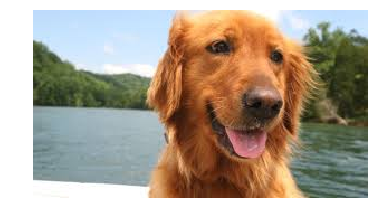

In [66]:
make_prediction('test_dogs/retriever downloaded.jpg')

Loading image...
Predicting breed...
Hi i am a human!
If I were a dog, I'd be a ucher mountain dog.


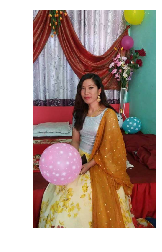

In [76]:
make_prediction('images/ashmita.jpg', multiple_breeds = True)

Loading image...
Predicting breed...


ValueError: Could not detect dogs or humans in image.

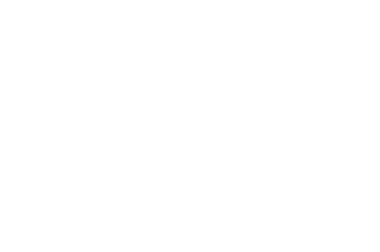

In [57]:
make_prediction('images/cat.jpg')

Loading image...
Extracting bottleneck features...
Feeding bottlenneck features into top model...
Predicting breed...
You look like a an water spaniel.


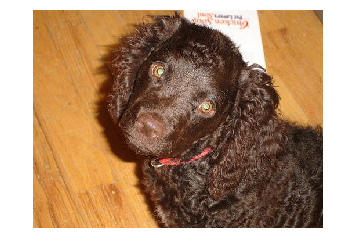

In [60]:
make_prediction('images/American_water_spaniel_00648.jpg')

Loading image...
Predicting breed...
You look like a  dog.


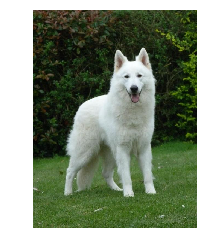

In [71]:
make_prediction('images/whiteShepherd.jpg')

Loading image...
Predicting breed...
You look like a .


Top 4 predictions (for mixed breeds)
Predicted breed:  with a confidence of 0.3846
Predicted breed: e crested with a confidence of 0.1678
Predicted breed: h toy spaniel with a confidence of 0.1078
Predicted breed: an foxhound with a confidence of 0.1053


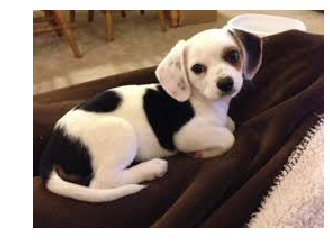

In [52]:
make_prediction('images/mixed breed.jpg', multiple_breeds = True)

Loading image...
Predicting breed...
Hi i am a human!
If I were a dog, I'd be a orso.


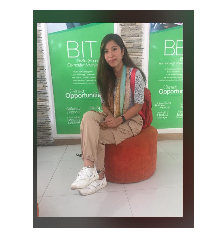

In [77]:
make_prediction('images/human.jpg')

Loading image...
Predicting breed...
You look like a oated retriever.


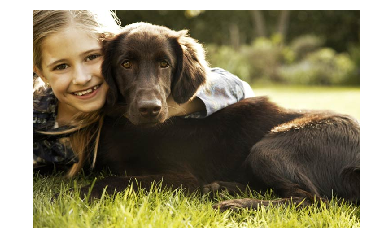

In [40]:
make_prediction('images/dog and human.jpg')

Loading image...
Extracting bottleneck features...
Feeding bottlenneck features into top model...
Predicting breed...
Woof woof!
You look like a Norwegian lundehund.


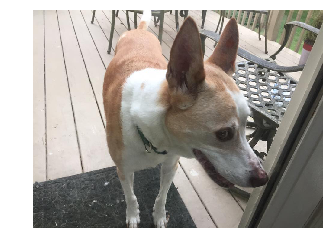

In [73]:
make_prediction('images/jason2.jpg')

Loading image...
Extracting bottleneck features...
Feeding bottlenneck features into top model...
Predicting breed...
Woof woof!
You look like a Maltese.


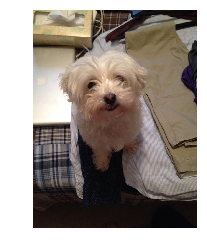

In [74]:
make_prediction('images/will.jpg')

In [ ]:
make_prediction('images/chelsea.jpg', multiple_breeds = True)

Loading image...


In [79]:
make_prediction('images/kendall.jpg', multiple_breeds = True)

Loading image...


FileNotFoundError: [Errno 2] No such file or directory: 'images/kendall.jpg'

Loading image...
Extracting bottleneck features...
Feeding bottlenneck features into top model...
Predicting breed...
Woof woof!
You look like a Parson russell terrier.


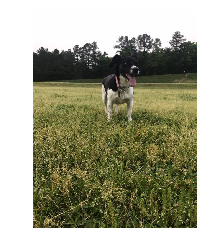

In [77]:
make_prediction('images/andii.jpg')

Loading image...
Extracting bottleneck features...
Feeding bottlenneck features into top model...
Predicting breed...
Woof woof!
You look like a Manchester terrier.


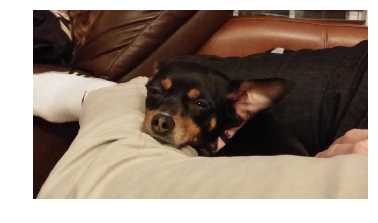

In [79]:
make_prediction('images/chase.jpeg')

In [56]:
make_prediction('images/zoinks.jpg')

Loading image...


FileNotFoundError: [Errno 2] No such file or directory: 'images/zoinks.jpg'

Loading image...
Extracting bottleneck features...
Feeding bottlenneck features into top model...
Predicting breed...
Woof woof!
You look like a Bichon frise.


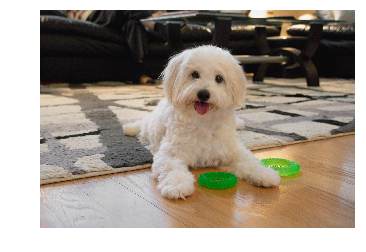

In [81]:
make_prediction('images/jimmy.jpg')

Loading image...
Extracting bottleneck features...
Feeding bottlenneck features into top model...
Predicting breed...
Woof woof!
You look like a Pomeranian.


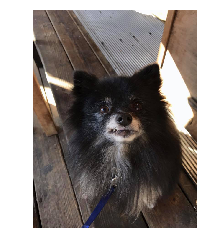

In [82]:
make_prediction('images/megan.jpg')

Loading image...
Extracting bottleneck features...
Feeding bottlenneck features into top model...
Predicting breed...
Woof woof!
You look like a Nova scotia duck tolling retriever.


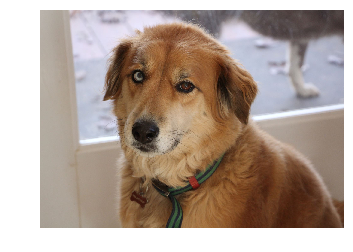

In [83]:
make_prediction('images/tea1.jpg')

In [55]:
make_prediction('images/tea2.jpg')

Loading image...


FileNotFoundError: [Errno 2] No such file or directory: 'images/tea2.jpg'

Loading image...
Extracting bottleneck features...
Feeding bottlenneck features into top model...
Predicting breed...
Woof woof!
You look like a Norwegian lundehund.


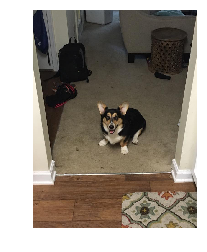

In [85]:
make_prediction('images/thomas.jpg')

In [1]:
make_prediction('images/jordan.jpg', multiple_breeds = True)

NameError: name 'make_prediction' is not defined

In [54]:
make_prediction('images/jessie1.jpg', multiple_breeds = True)

Loading image...


FileNotFoundError: [Errno 2] No such file or directory: 'images/jessie1.jpg'

Loading image...
Predicting breed...
You look like a ron.


Top 4 predictions (for mixed breeds)
Predicted breed: ron with a confidence of 0.5444
Predicted breed: ian shepherd dog with a confidence of 0.0845
Predicted breed: lian shepherd with a confidence of 0.0583
Predicted breed: an pinscher with a confidence of 0.0567


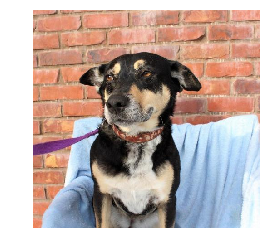

In [58]:
make_prediction('images/jessie2.jpg', multiple_breeds = True)

Loading image...
Extracting bottleneck features...
Feeding bottlenneck features into top model...
Predicting breed...
Woof woof!
You look like a Flat-coated retriever.


Top 4 predictions (for mixed breeds)
Predicted breed: Flat-coated retriever with a confidence of 0.4988
Predicted breed: Labrador retriever with a confidence of 0.4839
Predicted breed: Greyhound with a confidence of 0.0050
Predicted breed: Newfoundland with a confidence of 0.0031


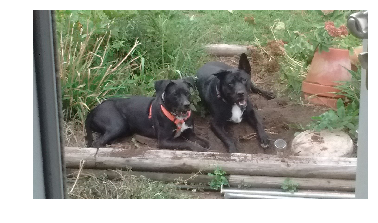

In [91]:
make_prediction('images/george.jpg', multiple_breeds = True)

Loading image...
Extracting bottleneck features...
Feeding bottlenneck features into top model...
Predicting breed...
Woof woof!
You look like a Beauceron.


Top 4 predictions (for mixed breeds)
Predicted breed: Beauceron with a confidence of 0.2818
Predicted breed: Airedale terrier with a confidence of 0.2697
Predicted breed: Australian cattle dog with a confidence of 0.1548
Predicted breed: Australian shepherd with a confidence of 0.0476


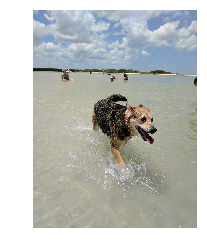

In [92]:
make_prediction('images/jessie3.jpg', multiple_breeds = True)

Loading image...
Extracting bottleneck features...
Feeding bottlenneck features into top model...
Predicting breed...
Woof woof!
You look like a American staffordshire terrier.


Top 4 predictions (for mixed breeds)
Predicted breed: American staffordshire terrier with a confidence of 0.6332
Predicted breed: Cane corso with a confidence of 0.3428
Predicted breed: Boxer with a confidence of 0.0084
Predicted breed: Chinese shar-pei with a confidence of 0.0039


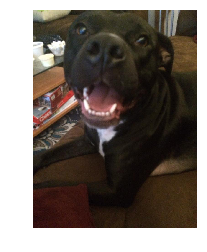

In [93]:
make_prediction('images/jenny.jpg', multiple_breeds = True)

Loading image...
Extracting bottleneck features...
Feeding bottlenneck features into top model...
Predicting breed...
Woof woof!
You look like a Anatolian shepherd dog.


Top 4 predictions (for mixed breeds)
Predicted breed: Anatolian shepherd dog with a confidence of 0.2961
Predicted breed: Pointer with a confidence of 0.2753
Predicted breed: Great dane with a confidence of 0.2406
Predicted breed: Labrador retriever with a confidence of 0.0639


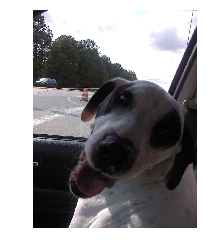

In [94]:
make_prediction('images/ally.jpg', multiple_breeds = True)

Loading image...
Extracting bottleneck features...
Feeding bottlenneck features into top model...
Predicting breed...
Woof woof!
You look like a Parson russell terrier.


Top 4 predictions (for mixed breeds)
Predicted breed: Parson russell terrier with a confidence of 0.9378
Predicted breed: Smooth fox terrier with a confidence of 0.0129
Predicted breed: Irish terrier with a confidence of 0.0107
Predicted breed: Chinese shar-pei with a confidence of 0.0095


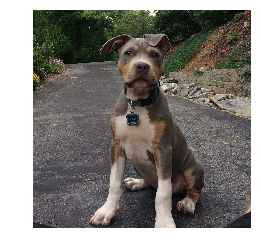

In [95]:
make_prediction('images/lane.jpg', multiple_breeds = True)

Loading image...
Extracting bottleneck features...
Feeding bottlenneck features into top model...
Predicting breed...
Woof woof!
You look like a Akita.


Top 4 predictions (for mixed breeds)
Predicted breed: Akita with a confidence of 0.4406
Predicted breed: Norwegian buhund with a confidence of 0.1765
Predicted breed: Icelandic sheepdog with a confidence of 0.1410
Predicted breed: Boxer with a confidence of 0.0970


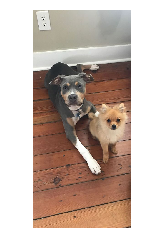

In [96]:
make_prediction('images/lane2.jpg', multiple_breeds = True)

Loading image...
Extracting bottleneck features...
Feeding bottlenneck features into top model...
Predicting breed...
Woof woof!
You look like a Finnish spitz.


Top 4 predictions (for mixed breeds)
Predicted breed: Finnish spitz with a confidence of 0.3524
Predicted breed: Akita with a confidence of 0.2076
Predicted breed: Cairn terrier with a confidence of 0.1674
Predicted breed: Canaan dog with a confidence of 0.1215


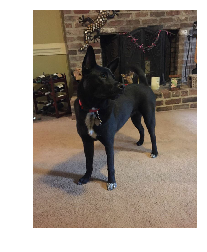

In [97]:
make_prediction('images/hannah.jpg', multiple_breeds = True)

Loading image...
Extracting bottleneck features...
Feeding bottlenneck features into top model...
Predicting breed...
Woof woof!
You look like a Dachshund.


Top 4 predictions (for mixed breeds)
Predicted breed: Dachshund with a confidence of 0.9012
Predicted breed: German pinscher with a confidence of 0.0764
Predicted breed: Manchester terrier with a confidence of 0.0075
Predicted breed: Plott with a confidence of 0.0058


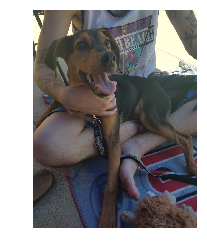

In [99]:
make_prediction('images/meganh.jpg', multiple_breeds = True)

Loading image...
Extracting bottleneck features...
Feeding bottlenneck features into top model...
Predicting breed...
Woof woof!
You look like a Beauceron.


Top 4 predictions (for mixed breeds)
Predicted breed: Beauceron with a confidence of 0.8684
Predicted breed: Dachshund with a confidence of 0.1001
Predicted breed: Doberman pinscher with a confidence of 0.0194
Predicted breed: German pinscher with a confidence of 0.0035


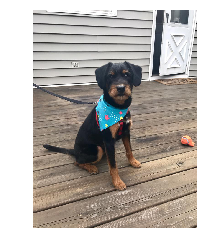

In [100]:
make_prediction('images/logan.jpg', multiple_breeds = True)

Loading image...
Extracting bottleneck features...
Feeding bottlenneck features into top model...
Predicting breed...


ValueError: Could not detect dogs or humans in image.

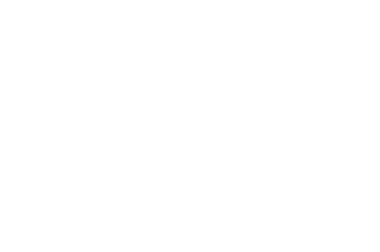

In [101]:
make_prediction('images/snoop.jpg')

Loading image...
Extracting bottleneck features...
Feeding bottlenneck features into top model...
Predicting breed...
Woof woof!
You look like a Dogue de bordeaux.


Top 4 predictions (for mixed breeds)
Predicted breed: Dogue de bordeaux with a confidence of 0.9620
Predicted breed: Labrador retriever with a confidence of 0.0152
Predicted breed: Nova scotia duck tolling retriever with a confidence of 0.0100
Predicted breed: Plott with a confidence of 0.0048


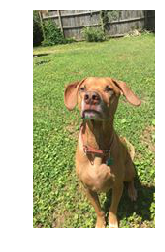

In [102]:
make_prediction('images/alina.jpg', multiple_breeds = True)

Loading image...
Extracting bottleneck features...
Feeding bottlenneck features into top model...
Predicting breed...
Woof woof!
You look like a Cairn terrier.


Top 4 predictions (for mixed breeds)
Predicted breed: Cairn terrier with a confidence of 0.9514
Predicted breed: Icelandic sheepdog with a confidence of 0.0118
Predicted breed: Lhasa apso with a confidence of 0.0103
Predicted breed: Norwegian buhund with a confidence of 0.0047


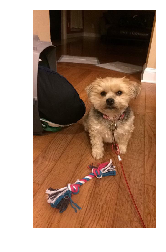

In [103]:
make_prediction('images/melissa1.jpg', multiple_breeds = True)

Loading image...
Extracting bottleneck features...
Feeding bottlenneck features into top model...
Predicting breed...
Woof woof!
You look like a Cairn terrier.


Top 4 predictions (for mixed breeds)
Predicted breed: Cairn terrier with a confidence of 0.9554
Predicted breed: Icelandic sheepdog with a confidence of 0.0259
Predicted breed: Finnish spitz with a confidence of 0.0045
Predicted breed: Norfolk terrier with a confidence of 0.0032


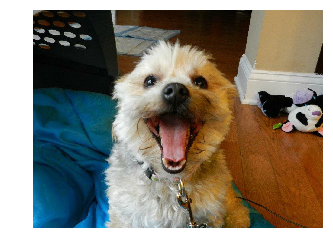

In [104]:
make_prediction('images/melissa2.jpg', multiple_breeds = True)

Loading image...
Extracting bottleneck features...
Feeding bottlenneck features into top model...
Predicting breed...


ValueError: Could not detect dogs or humans in image.

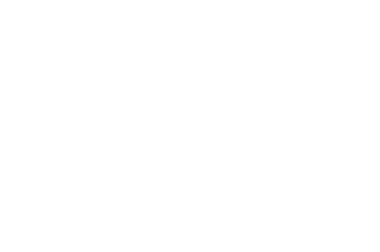

In [105]:
make_prediction('images/taylor.jpg')

Loading image...
Extracting bottleneck features...
Feeding bottlenneck features into top model...
Predicting breed...
Woof woof!
You look like a Lhasa apso.


Top 4 predictions (for mixed breeds)
Predicted breed: Lhasa apso with a confidence of 0.6122
Predicted breed: Lowchen with a confidence of 0.2190
Predicted breed: Havanese with a confidence of 0.1025
Predicted breed: Icelandic sheepdog with a confidence of 0.0198


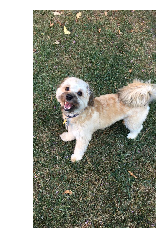

In [31]:
make_prediction('images/akash.jpg', multiple_breeds = True)

Loading image...
Extracting bottleneck features...
Feeding bottlenneck features into top model...
Predicting breed...
Woof woof!
You look like a American foxhound.


Top 4 predictions (for mixed breeds)
Predicted breed: American foxhound with a confidence of 0.8576
Predicted breed: Beagle with a confidence of 0.1422
Predicted breed: Dachshund with a confidence of 0.0001
Predicted breed: Plott with a confidence of 0.0000


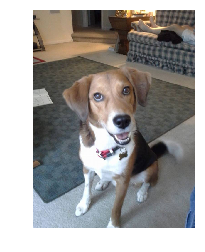

In [32]:
make_prediction('images/caleb.jpg', multiple_breeds = True)

Loading image...
Extracting bottleneck features...
Feeding bottlenneck features into top model...
Predicting breed...
Woof woof!
You look like a Nova scotia duck tolling retriever.


Top 4 predictions (for mixed breeds)
Predicted breed: Nova scotia duck tolling retriever with a confidence of 0.5648
Predicted breed: Leonberger with a confidence of 0.1677
Predicted breed: Golden retriever with a confidence of 0.1511
Predicted breed: Anatolian shepherd dog with a confidence of 0.0643


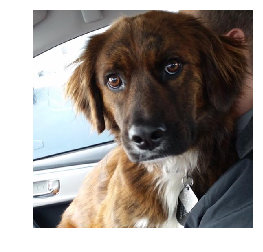

In [33]:
make_prediction('images/taylor.png', multiple_breeds = True)

Loading image...
Extracting bottleneck features...
Feeding bottlenneck features into top model...
Predicting breed...
Woof woof!
You look like a Chihuahua.


Top 4 predictions (for mixed breeds)
Predicted breed: Chihuahua with a confidence of 0.4925
Predicted breed: Norwegian buhund with a confidence of 0.2395
Predicted breed: Canaan dog with a confidence of 0.1754
Predicted breed: Cairn terrier with a confidence of 0.0232


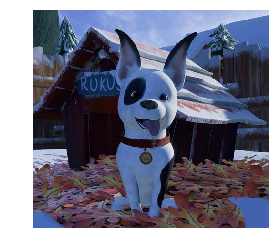

In [21]:
make_prediction('images/primus.png', multiple_breeds = True)